In [1]:
# 1. Importaciones y Configuración
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import time

# Directorio base
base_dir = "IA/data_images"

# 2. Preparación de Datos para Modelos V1 y V2
# 2.1 Generadores para CNN simple y AlexNet
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='validation'
)

print("Class indices:", train_generator.class_indices)

Found 351 images belonging to 3 classes.
Found 86 images belonging to 3 classes.
Class indices: {'Kobe Bryant': 0, 'Maria Sharapova': 1, 'ronaldo': 2}


<Figure size 2000x400 with 0 Axes>

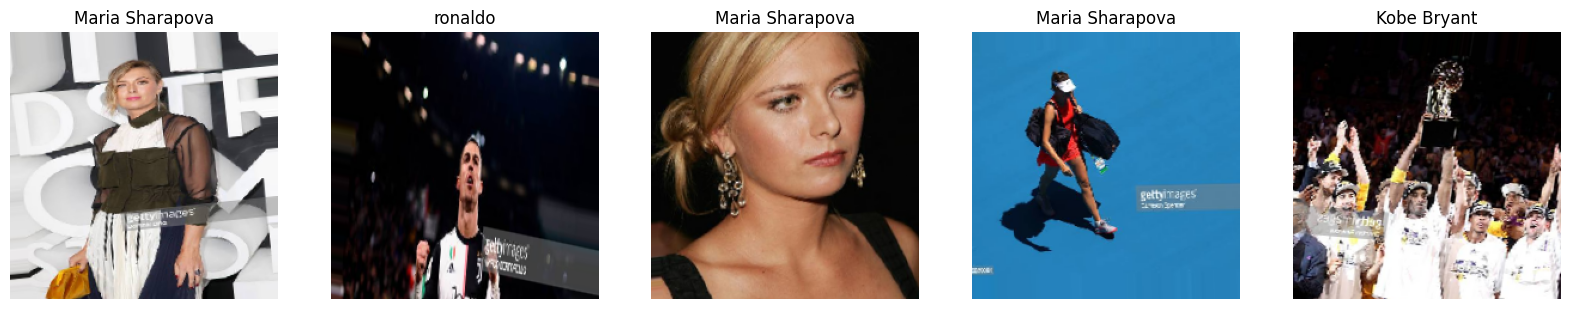

In [2]:
# 2.2 Visualización de muestras
plt.figure(figsize=(20, 4))
f, axarr = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    images, labels = next(train_generator)
    axarr[i].imshow(images[0])
    axarr[i].axis("off")
    class_idx = np.argmax(labels[0])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    axarr[i].set_title(class_name)

plt.show()

In [3]:
# 3. Modelo V2 - Inspirado en AlexNet
def build_alexnet_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(3, activation='softmax'))
    
    return model

# Construir y compilar modelo AlexNet
model = build_alexnet_model()
model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=2e-5),
    metrics=['accuracy']
)

# Entrenar modelo AlexNet
history_alexnet = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator
)

/Users/randuretana/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    88,605,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,977,539 (339.42 MB)

 Trainable params: 88,977,539 (339.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/Users/randuretana/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 358ms/step - accuracy: 0.3962 - loss: 1.0858 - val_accuracy: 0.5349 - val_loss: 1.0354
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 331ms/step - accuracy: 0.4346 - loss: 1.0715 - val_accuracy: 0.5233 - val_loss: 1.0161
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 332ms/step - accuracy: 0.4766 - loss: 1.0141 - val_accuracy: 0.5116 - val_loss: 0.9978
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 333ms/step - accuracy: 0.5666 - loss: 0.9856 - val_accuracy: 0.5581 - val_loss: 0.9590
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step - accuracy: 0.5180 - loss: 0.9759 - val_accuracy: 0.5465 - val_loss: 0.9630
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 330ms/step - accuracy: 0.5665 - loss: 1.0080 - val_accuracy: 0.5698 - val_loss: 0.9220
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 354ms/step - accuracy: 0.6120 - loss: 0.8659 - val_accuracy: 0.4884 - val_loss: 1.0277
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 357ms/step - accuracy: 0.5911 - loss: 0.8838 - val_accuracy

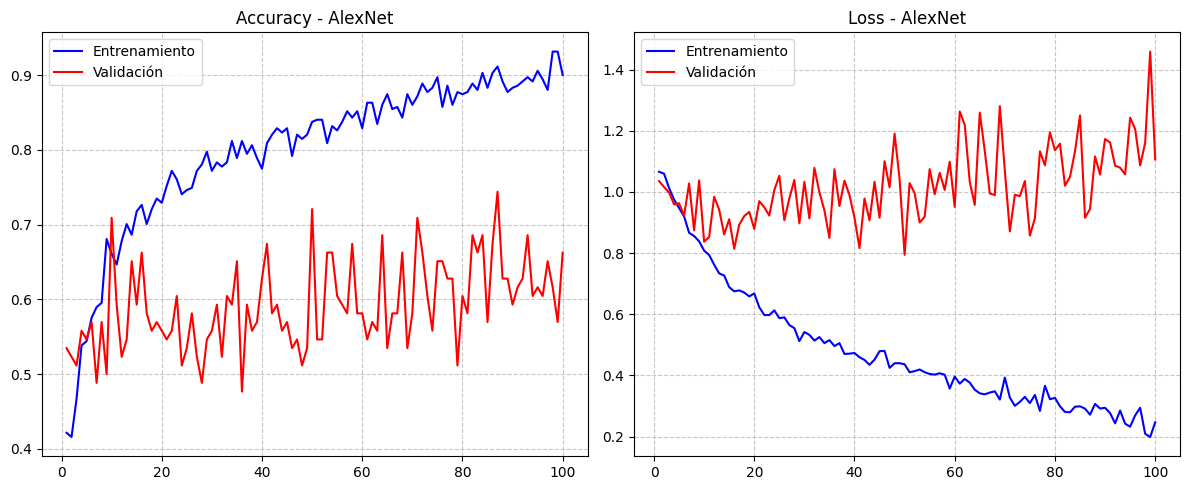

In [4]:
# Visualizar resultados AlexNet
acc = history_alexnet.history['accuracy']
val_acc = history_alexnet.history.get('val_accuracy', [])
loss = history_alexnet.history['loss']
val_loss = history_alexnet.history.get('val_loss', [])

epochs = range(1, len(acc)+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Entrenamiento')
if val_acc:
    plt.plot(epochs, val_acc, 'r-', label='Validación')
plt.title('Accuracy - AlexNet')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Entrenamiento')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validación')
plt.title('Loss - AlexNet')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Guardar modelo AlexNet
model.save('model_v2_alexnet.h5')

In [5]:
# 4. Modelo V3 - Transfer Learning con MobileNetV2
def build_mobilenetv2_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    # Superior layers 
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

# Construir y compilar modelo MobileNetV2
model2, base_model_mobile = build_mobilenetv2_model()
model2.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Callbacks para entrenamiento
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2)
]

# Fase 1: Entrenar capas superiores
history_mobile = model2.fit(
    train_generator, 
    epochs=10, 
    validation_data=val_generator, 
    callbacks=callbacks
)

# Fase 2: Fine-tuning
base_model_mobile.trainable = True
for layer in base_model_mobile.layers[:-20]:  # Congelar todas menos las últimas 20 capas
    layer.trainable = False

model2.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

history_mobile_finetune = model2.fit(
    train_generator, 
    epochs=10, 
    validation_data=val_generator, 
    callbacks=callbacks
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.4839 - loss: 1.2244 - val_accuracy: 0.6047 - val_loss: 0.8475 - learning_rate: 1.0000e-04
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.6016 - loss: 0.9583 - val_accuracy: 0.6512 - val_loss: 0.7277 - learning_rate: 1.0000e-04
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.6815 - loss: 0.7137 - val_accuracy: 0.7209 - val_loss: 0.6421 - learning_rate: 1.0000e-04
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.7457 - loss: 0.6908 - val_accuracy: 0.7791 - val_loss: 0.5609 - learning_rate: 1.0000e-04
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8179 - loss: 0.4982 - val_accuracy: 0.8605 - val_loss: 0.4534 - learning_rate: 1.0000e-04
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8181 - loss: 0.4819 - val_accuracy: 0.8372 - val_loss: 0.4471 - learning_rate: 1.0000e-04
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8594 

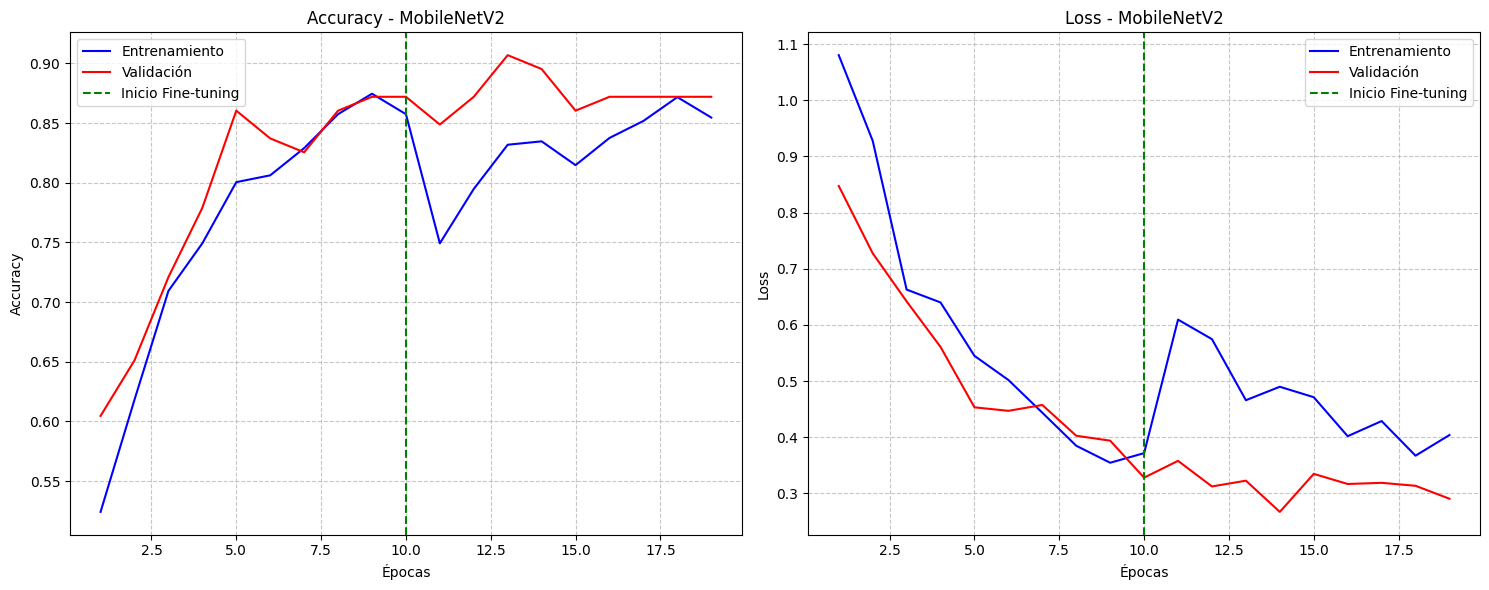

In [6]:
# Visualizar resultados MobileNetV2
def plot_training_history(history1, history2=None, title="Rendimiento del Modelo"):
    # Combinar historiales si hay dos fases
    if history2:
        acc = history1.history['accuracy'] + history2.history['accuracy']
        val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
        loss = history1.history['loss'] + history2.history['loss']
        val_loss = history1.history['val_loss'] + history2.history['val_loss']
        
        # Marcar punto de inicio de fine-tuning
        phase1_len = len(history1.history['accuracy'])
    else:
        acc = history1.history['accuracy']
        val_acc = history1.history.get('val_accuracy', [])
        loss = history1.history['loss']
        val_loss = history1.history.get('val_loss', [])
        phase1_len = None
    
    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(15, 6))
    
    # Graficar accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'b-', label='Entrenamiento')
    plt.plot(epochs_range, val_acc, 'r-', label='Validación')
    if phase1_len:
        plt.axvline(x=phase1_len, color='g', linestyle='--', label='Inicio Fine-tuning')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Graficar loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'b-', label='Entrenamiento')
    plt.plot(epochs_range, val_loss, 'r-', label='Validación')
    if phase1_len:
        plt.axvline(x=phase1_len, color='g', linestyle='--', label='Inicio Fine-tuning')
    plt.title(f'Loss - {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Visualizar rendimiento de MobileNetV2
plot_training_history(history_mobile, history_mobile_finetune, "MobileNetV2")

# Guardar modelo MobileNetV2
model2.save('model_v3_mobilenet.h5')

In [9]:
# 5. Modelo V4 - Transfer Learning con ResNet50

def build_resnet50_model():
    # Cargar ResNet50 preentrenada
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Congelar inicialmente

    # Construir el modelo completo
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Primera capa densa más grande
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    # Segunda capa densa
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    # Capa de salida con 3 clases
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

# Preparar generadores específicos para ResNet50
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Preprocesamiento específico de ResNet50
    rotation_range=20,  # Aumentado para más variedad
    width_shift_range=0.2,
    height_shift_range=0.2,  # Añadido para más variedad
    zoom_range=0.3,
    shear_range=0.1,  # Añadido para más variedad
    horizontal_flip=True,
    validation_split=0.2
)

train_generator_resnet = train_datagen_resnet.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=16,  # Aumentado para mejor convergencia
    class_mode='categorical',
    subset='training',
    shuffle=True  
)

val_generator_resnet = train_datagen_resnet.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

print("Class indices para ResNet50:", train_generator_resnet.class_indices)

# Registrar tiempo inicial para medir duración del entrenamiento
start_time = time.time()

# Construir y compilar modelo ResNet50
model_resnet, base_model_resnet = build_resnet50_model()
model_resnet.compile(
    optimizer=Adam(learning_rate=0.00005),  # Tasa de aprendizaje inicial
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks para el entrenamiento
callbacks_resnet = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Fase 1: Entrenar capas superiores
history_resnet = model_resnet.fit(
    train_generator_resnet,
    epochs=15,
    validation_data=val_generator_resnet,
    callbacks=callbacks_resnet,
    verbose=1
)

# Fase 2: Fine-tuning
base_model_resnet.trainable = True

# Congelar las primeras capas y dejar las últimas para entrenar
for layer in base_model_resnet.layers[:100]:
    layer.trainable = False

# Recompilar con tasa de aprendizaje más baja para fine-tuning
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-6),  # Tasa mucho más baja para fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Segundo entrenamiento (fine-tuning)
history_resnet_finetune = model_resnet.fit(
    train_generator_resnet,
    epochs=20,
    validation_data=val_generator_resnet,
    callbacks=callbacks_resnet,
    verbose=1
)



Found 351 images belonging to 3 classes.
Found 86 images belonging to 3 classes.
Class indices para ResNet50: {'Kobe Bryant': 0, 'Maria Sharapova': 1, 'ronaldo': 2}
Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 405ms/step - accuracy: 0.3502 - loss: 1.4210 - val_accuracy: 0.5930 - val_loss: 0.9683 - learning_rate: 5.0000e-05
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.4821 - loss: 1.1618 - val_accuracy: 0.6512 - val_loss: 0.8401 - learning_rate: 5.0000e-05
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.5660 - loss: 0.9343 - val_accuracy: 0.6860 - val_loss: 0.7411 - learning_rate: 5.0000e-05
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - accuracy: 0.6071 - loss: 0.8358 - val_accuracy: 0.6047 - val_loss: 0.7233 - learning_rate: 5.0000e-05
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.6712 - loss: 0.7659 - val_accuracy: 0.7442 - val_loss: 0.6012 - learning_rate: 5.0000e-05
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step - 


Tiempo total de entrenamiento: 5.87 minutos


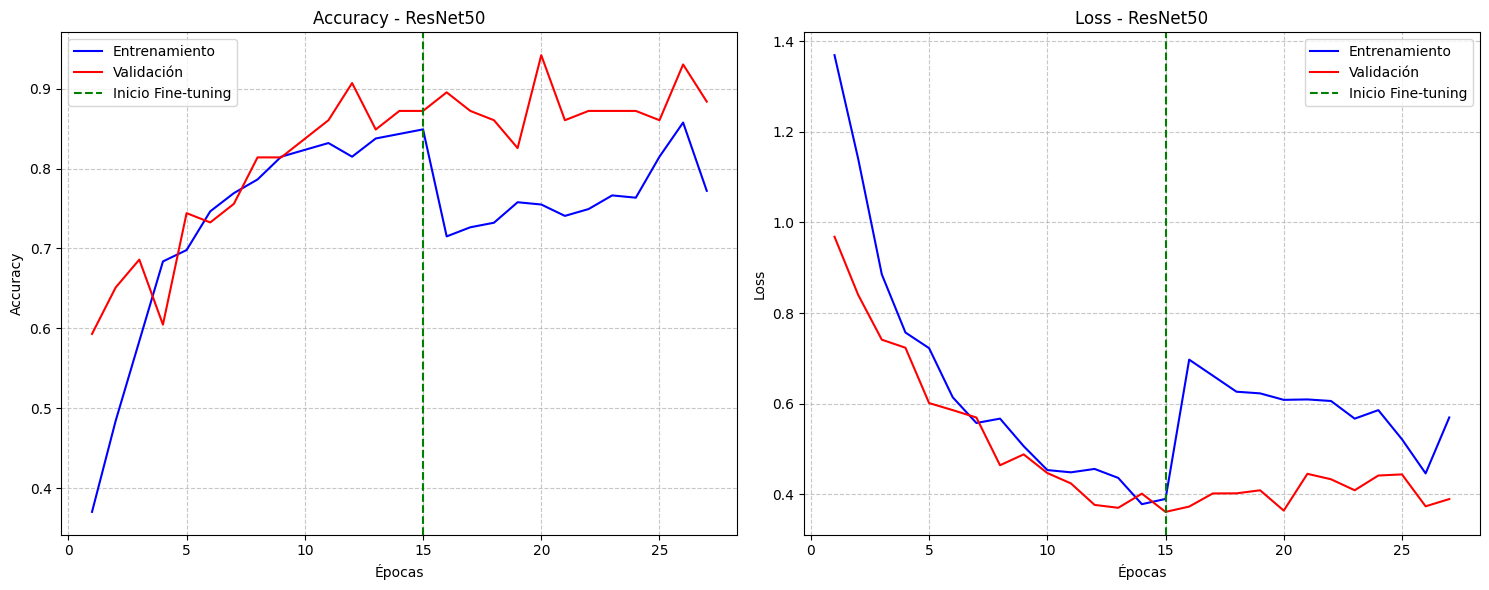

In [10]:
# Tiempo total de entrenamiento
total_time = time.time() - start_time
print(f"\nTiempo total de entrenamiento: {total_time/60:.2f} minutos")

# Visualizar rendimiento de ResNet50
plot_training_history(history_resnet, history_resnet_finetune, "ResNet50")

# Guardar modelo ResNet50
model_resnet.save('model_v4_resnet50.h5')

In [19]:

# 6. Evaluación y Comparación de Modelos
# 6.1 Función para evaluar modelos
def evaluate_model(model, generator, model_name):
    print(f"\nEvaluando modelo: {model_name}")
    
    # Medir tiempo de inferencia
    start_time = time.time()
    predictions = model.predict(generator)
    inference_time = time.time() - start_time
    
    # Calcular métricas
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    
    # Evaluación formal
    loss, accuracy = model.evaluate(generator, verbose=0)
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualizar matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(generator.class_indices.keys()),
                yticklabels=list(generator.class_indices.keys()))
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'loss': loss,
        'inference_time': inference_time,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_true': y_true
    }

In [20]:
# 6.2 Preparar generadores para evaluación

# Para AlexNet y MobileNetV2
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Para ResNet50 
test_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input  # Esto es crucial para ResNet50
)
test_generator_resnet = test_datagen_resnet.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 437 images belonging to 3 classes.
Found 437 images belonging to 3 classes.



Evaluando modelo: AlexNet (V2.0)


/Users/randuretana/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step


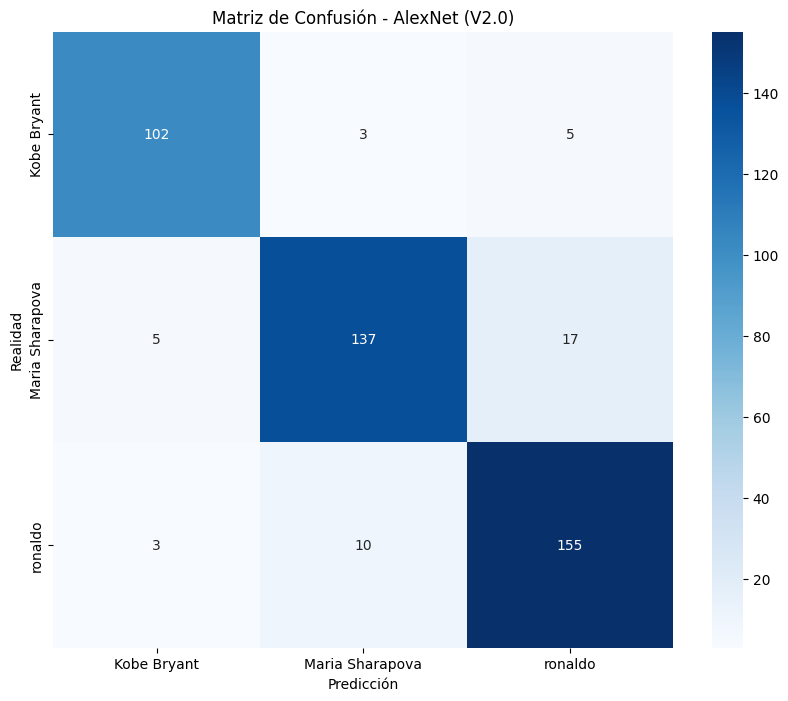


Evaluando modelo: MobileNetV2 (V3.0)
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step


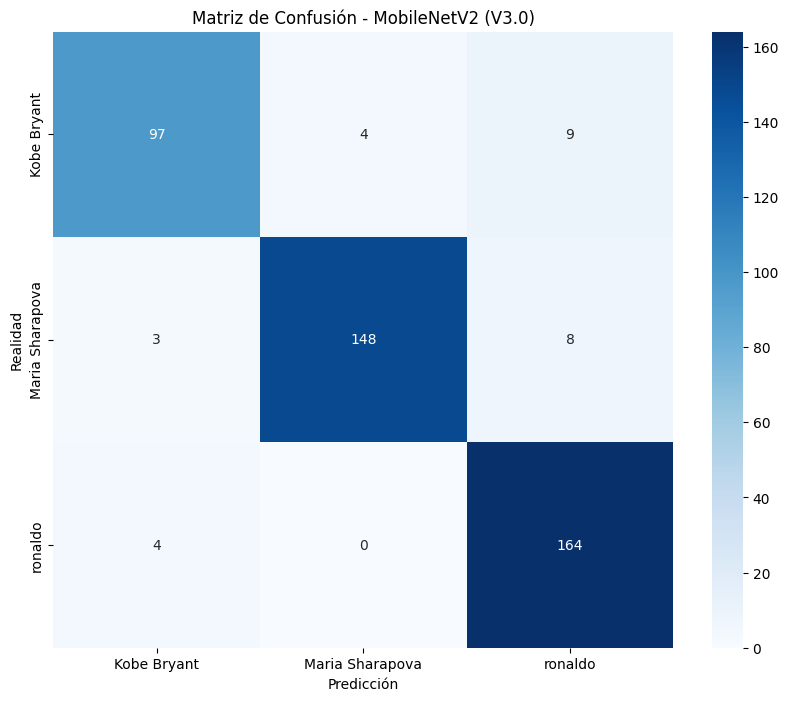


Evaluando modelo: ResNet50 (V4.0)


/Users/randuretana/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 506ms/step


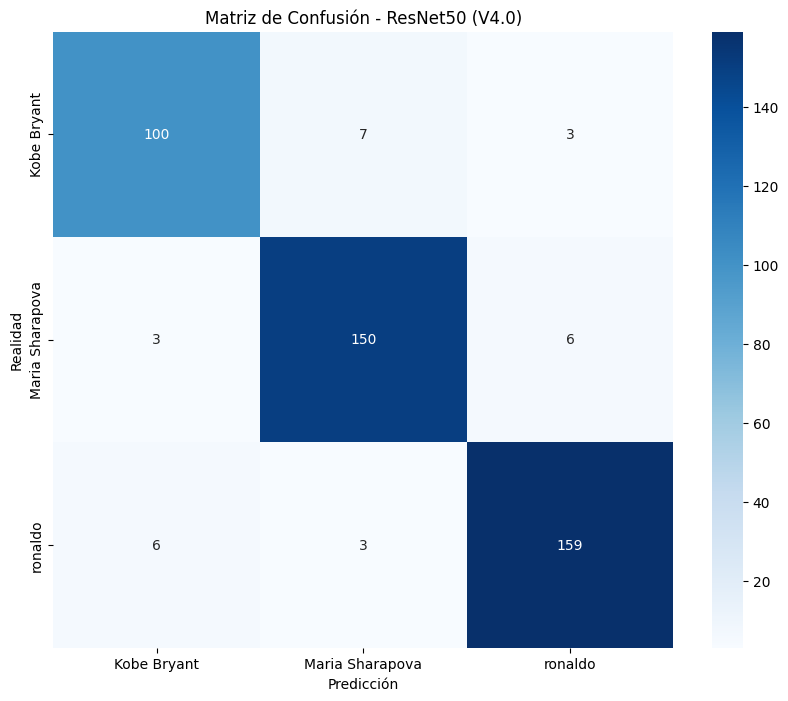


Comparativa de Métricas de Rendimiento:
               Modelo  Accuracy      Loss  Tiempo de Inferencia (s)  \
0      AlexNet (V2.0)  0.901602  0.280216                  4.053514   
1  MobileNetV2 (V3.0)  0.935927  0.196460                  2.400849   
2     ResNet50 (V4.0)  0.935927  0.249861                  7.212403   

   Parámetros (M)  
0             8.5  
1             3.5  
2            25.6  


/var/folders/y6/dgqpbycn7cg4zjgztw46l9ch0000gn/T/ipykernel_48229/917623920.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='Accuracy', data=metrics_df, palette='viridis')
/var/folders/y6/dgqpbycn7cg4zjgztw46l9ch0000gn/T/ipykernel_48229/917623920.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='Loss', data=metrics_df, palette='viridis')
/var/folders/y6/dgqpbycn7cg4zjgztw46l9ch0000gn/T/ipykernel_48229/917623920.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='Tiempo de Inferencia (s)', d

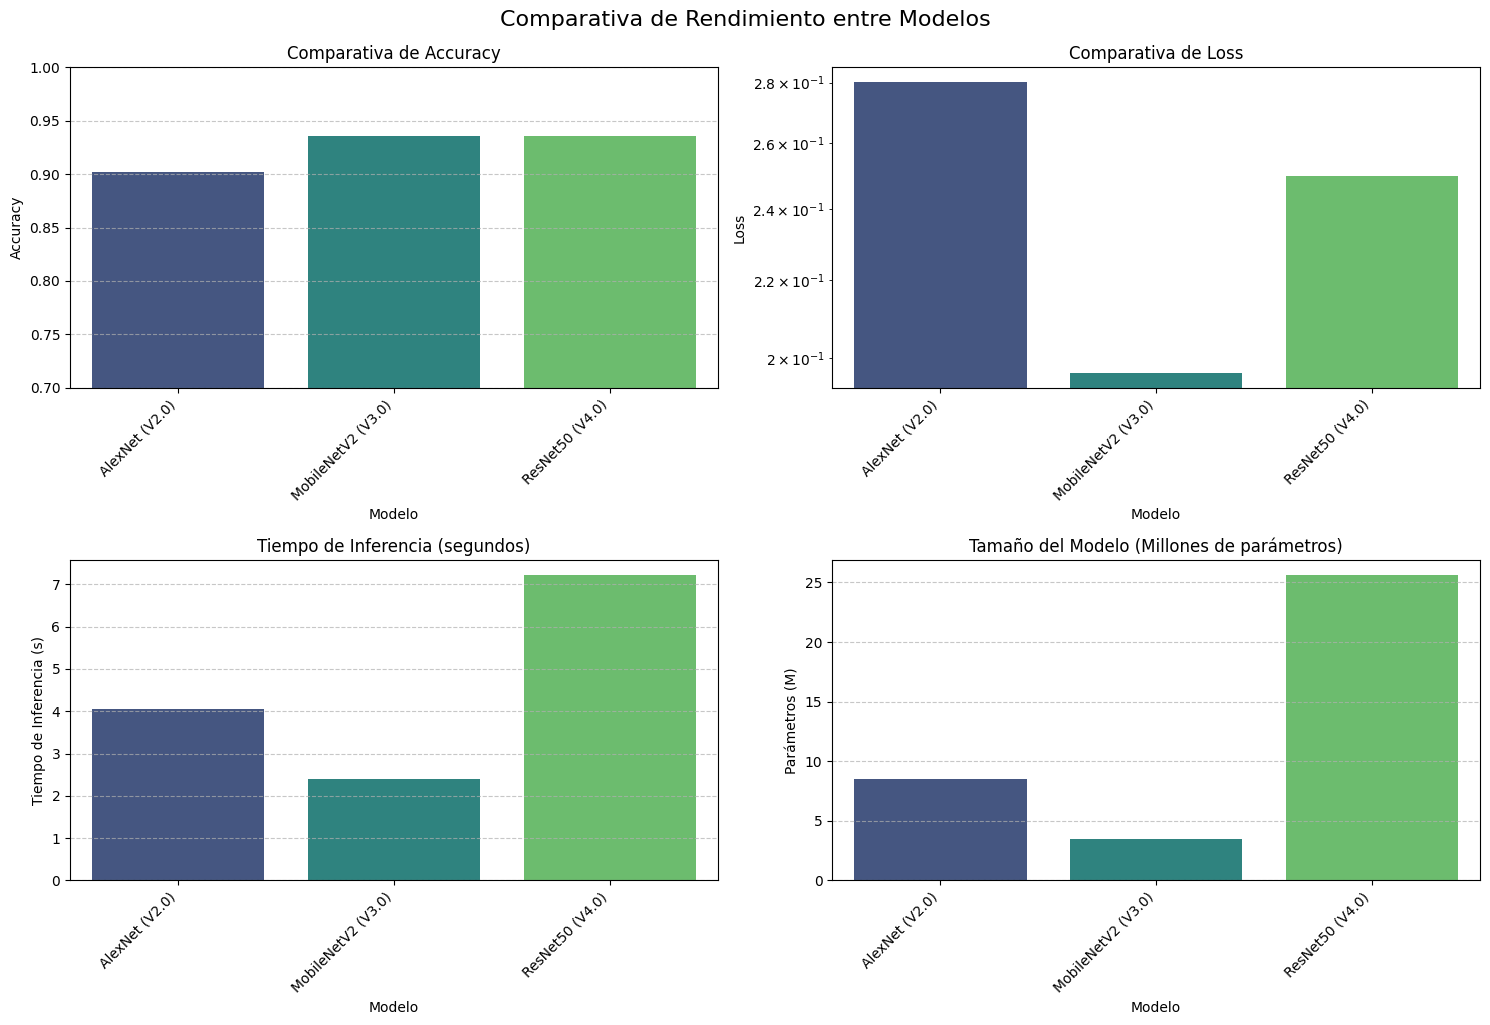

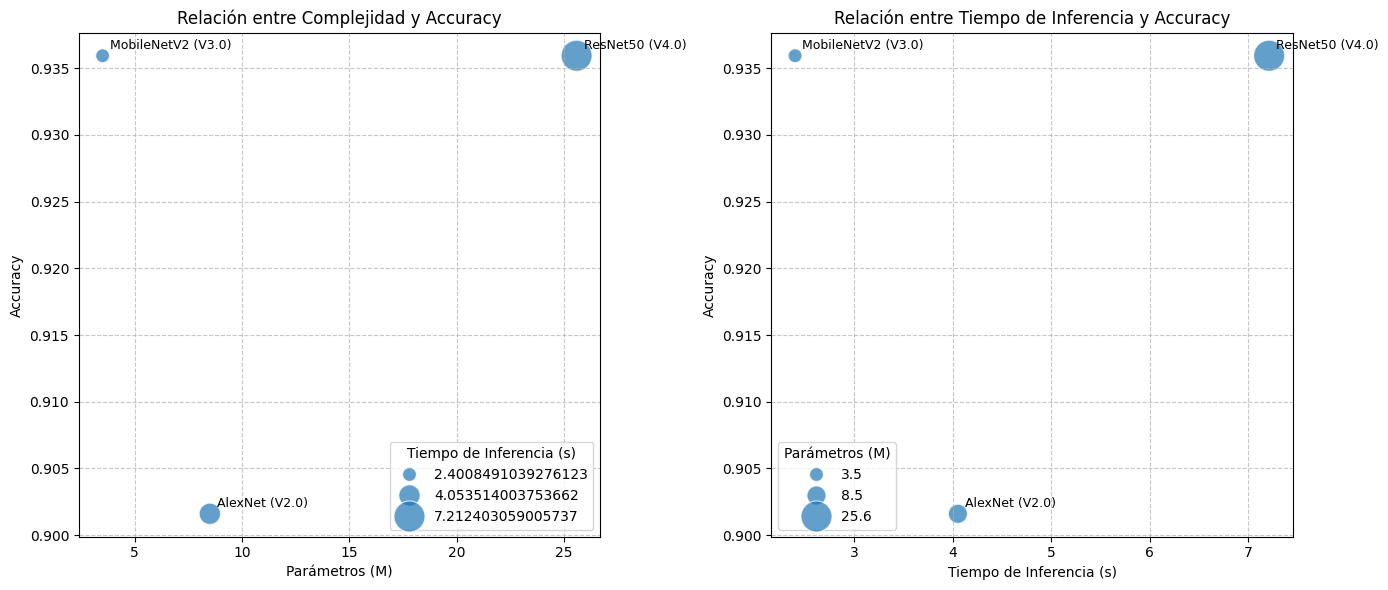

In [ ]:
# 6.3 Evaluar cada modelo
results = []

# Evaluar AlexNet (V2.0)
results.append(evaluate_model(model, test_generator, "AlexNet (V2.0)"))

# Evaluar MobileNetV2 (V3.0)
results.append(evaluate_model(model2, test_generator, "MobileNetV2 (V3.0)"))

# Evaluar ResNet50 (V4.0)
results.append(evaluate_model(model_resnet, test_generator_resnet, "ResNet50 (V4.0)"))

# 6.4 Comparativa visual
metrics_df = pd.DataFrame({
    'Modelo': [r['model_name'] for r in results],
    'Accuracy': [r['accuracy'] for r in results],
    'Loss': [r['loss'] for r in results],
    'Tiempo de Inferencia (s)': [r['inference_time'] for r in results]
})

param_counts = {
    "AlexNet (V2.0)": 8.5,
    "MobileNetV2 (V3.0)": 3.5,
    "ResNet50 (V4.0)": 25.6
}

metrics_df['Parámetros (M)'] = [param_counts.get(m, 0) for m in metrics_df['Modelo']]

print("\nComparativa de Métricas de Rendimiento:")
print(metrics_df)

# Visualización de métricas principales
plt.figure(figsize=(15, 10))

# Gráfico de barras para accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Modelo', y='Accuracy', data=metrics_df, palette='viridis')
plt.title('Comparativa de Accuracy')
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico de barras para loss
plt.subplot(2, 2, 2)
sns.barplot(x='Modelo', y='Loss', data=metrics_df, palette='viridis')
plt.title('Comparativa de Loss')
plt.yscale('log') 
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico de tiempo de inferencia
plt.subplot(2, 2, 3)
sns.barplot(x='Modelo', y='Tiempo de Inferencia (s)', data=metrics_df, palette='viridis')
plt.title('Tiempo de Inferencia (segundos)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico de tamaño del modelo
plt.subplot(2, 2, 4)
sns.barplot(x='Modelo', y='Parámetros (M)', data=metrics_df, palette='viridis')
plt.title('Tamaño del Modelo (Millones de parámetros)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle('Comparativa de Rendimiento entre Modelos', fontsize=16, y=1.02)
plt.show()

# 6.5 Análisis de correlación entre complejidad y rendimiento
plt.figure(figsize=(14, 6))

# Scatter plot: Parámetros vs Accuracy
plt.subplot(1, 2, 1)
sns.scatterplot(x='Parámetros (M)', y='Accuracy', 
                size='Tiempo de Inferencia (s)', 
                sizes=(100, 500), 
                data=metrics_df, 
                alpha=0.7)

# Añadir etiquetas a cada punto
for i, row in metrics_df.iterrows():
    plt.annotate(row['Modelo'], 
                (row['Parámetros (M)'], row['Accuracy']),
                fontsize=9,
                xytext=(5, 5),
                textcoords='offset points')

plt.title('Relación entre Complejidad y Accuracy')
plt.grid(linestyle='--', alpha=0.7)

# Scatter plot: Tiempo de Inferencia vs Accuracy
plt.subplot(1, 2, 2)
sns.scatterplot(x='Tiempo de Inferencia (s)', y='Accuracy', 
                size='Parámetros (M)', 
                sizes=(100, 500), 
                data=metrics_df, 
                alpha=0.7)

# Añadir etiquetas a cada punto
for i, row in metrics_df.iterrows():
    plt.annotate(row['Modelo'], 
                (row['Tiempo de Inferencia (s)'], row['Accuracy']),
                fontsize=9,
                xytext=(5, 5),
                textcoords='offset points')

plt.title('Relación entre Tiempo de Inferencia y Accuracy')
plt.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()